El objetivo de esta práctica es comprobar como funciona una RNA como predictor. En concreto, usaremos como entrada los resultados económicos de un conjunto de empresas en Polonia, etiquetadas en función de si entraron en bancarrota a 5 años vista o no.

Es importante recordar que las redes se adaptan a los datos de entrenamiento, es decir, que el modelo resultante solo sería válido para Polonia y eso siempre que el panorama empresarial no tuviese cambios significativos de cuando se aplica a cuando se tomaron los datos de entrenamiento.

La práctica está adaptada y comentada a partir de la implementación de [Mateusz Dadej](https://www.kaggle.com/code/squintrook/forecasting-bankruptcies-with-ann).

Para empezar, hay que cargar las librerías necesarias, principalmente tensorflow para las RNN.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# Set the random seed for reproducibility
np.random.seed(2)
tf.random.set_seed(2)

A continuación, vamos preparar los datos para su procesado. Los datos vienen separados en 5 datasets correspondientes a años consecutivos (2007 a 2013) e incluyen 64 variables numéricas como beneficios totales, netos, intereses ... La variable a predecir (class) es binaria: si la compañia entró en bancarrota o no en 5 años, es decir, en el dataset de 1year (2007), la variable indicaría si se entró en bancarrota en 2013 y así sucesivamente.

Se puede encontrar la descripción de todos campos en https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data#

Como los ficheros son tipo arff, prepararemos una función para cargar los cinco que vamos a utilizar en un array (dataframes) y luego los combinaremos en un solo dataframe (df).

In [25]:
# Function to load ARFF files
def load_arff(url):
    from scipy.io import arff
    import requests
    import io

    response = requests.get(url)
    data, meta = arff.loadarff(io.StringIO(response.content.decode('utf-8')))
    return pd.DataFrame(data)

# Load the datasets
urls = [
    "https://github.com/crisurdiales/DataMining4SmartCities/blob/main/1year.arff?raw=true",
    "https://github.com/crisurdiales/DataMining4SmartCities/blob/main/2year.arff?raw=true",
    "https://github.com/crisurdiales/DataMining4SmartCities/blob/main/3year.arff?raw=true",
    "https://github.com/crisurdiales/DataMining4SmartCities/blob/main/4year.arff?raw=true",
    "https://github.com/crisurdiales/DataMining4SmartCities/blob/main/5year.arff?raw=true"
]

dataframes = [load_arff(url) for url in urls]

# Remove rows with missing values
dataframes = [df.dropna() for df in dataframes]

# Balance the datasets
dataframes[0] = dataframes[0].iloc[2828:3031]
dataframes[1] = dataframes[1].iloc[4530:4769]
dataframes[2] = dataframes[2].iloc[4672:4885]
dataframes[3] = dataframes[3].iloc[3943:4088]
dataframes[4] = dataframes[4].iloc[3135:3195]

# Combine all dataframes into one
df = pd.concat(dataframes)


Podemos comprobar la estructura de los datos y si falta algún valor.

In [26]:
summary_all = df.describe(include='all')
print(summary_all)
has_nan = df.isnull().values.any()
print(f"Does the DataFrame have any NaN or null values? {has_nan}")

             Attr1       Attr2       Attr3       Attr4        Attr5  \
count   561.000000  561.000000  561.000000  561.000000   561.000000   
unique         NaN         NaN         NaN         NaN          NaN   
top            NaN         NaN         NaN         NaN          NaN   
freq           NaN         NaN         NaN         NaN          NaN   
mean      0.047591    0.592225    0.122294    1.863334   -29.084920   
std       0.159758    0.388865    0.322939    1.605679   134.575671   
min      -0.958760    0.040666   -3.000000    0.056317 -1779.000000   
25%       0.003842    0.390950    0.008063    1.016500   -56.108000   
50%       0.046543    0.552250    0.147430    1.419400   -19.479000   
75%       0.111670    0.731930    0.295130    2.164300    15.179000   
max       1.842200    5.097000    0.801070   18.027000   634.110000   

             Attr6       Attr7       Attr8       Attr9      Attr10  ...  \
count   561.000000  561.000000  561.000000  561.000000  561.000000  ... 

A continuación comprobamos que todos los datos son numéricos. Como la variable dependiente es categórica, aplicaremos 1-hot encoding para hacerla numérica por conveniencia para la RNN.

In [27]:
print(df.dtypes)

#df = df.apply(pd.to_numeric)
# One-hot encoding for the 'class' column
df['class_2'] = df['class'].apply(lambda x: 1 if x == b'0' else 0)
df['class'] = df['class'].apply(lambda x: 0 if x == b'0' else 1)

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
class      object
Length: 65, dtype: object


In [ ]:
Finalmente, antes de entrenar, vamos a normalizar las variables independientes, separando previamente las dependientes para que sigan siendo 0 o 1.

In [29]:
# Verificar las columnas 'class' y 'class_2'
print(df[['class', 'class_2']].head())

# Separar características y etiquetas
X = df.drop(columns=['class', 'class_2'])
y = df[['class', 'class_2']]

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

      class  class_2
6045      0        1
6052      0        1
6053      0        1
6055      0        1
6058      0        1


Con los datos preprocesados, ya podemos dividir el conjunto en dos particiones, train y test, y entrenar la red.

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=2)

El modelo que vamos a utilizar es una red densa (todas las neuronas de cada capa se conectan con todas las de la capa siguiente) y consta de cuatro capas: entrada, salida y dos capas ocultas. En concreto, y dado que buscamos una solución sencilla, emplearemos la función de activación ReLU para todas las capas menos la de salida, que utiliza una función softmax:


*   La función ReLU (Rectified Linear Unit) se limita a devolver 0 para valores negativos de entrada y el propio valor en el resto de los casos. Su no linealidad permite que la red neuronal aprenda funciones complejas y no lineales.
*    Softmax es una función de activación muy común en la capa de salida para redes neuronales aplicadas a problemas de clasificación multiclase. Softmax toma como entrada un vector de valores reales y produce un vector de la misma longitud, donde cada elemento está en el rango de 0 a 1 y la suma de todos los elementos es 1, ésto es, devuelve  la probabilidad de que la entrada pertenezca a una clase específica (en nuestro caso, bancarrota o no bancarrota).



In [ ]:
# Build the neural network
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', name='input_layer'))
model.add(Dense(10, activation='relu', name='hidden_layer1'))
model.add(Dense(10, activation='relu', name='hidden_layer2'))
model.add(Dense(2, activation='softmax', name='output_layer'))

Una vez tenemos definidas las capas, indicaremos como se obtendrá el modelo y lo entrenaremos. En concreto vamos a emplear lo siguiente:


*   loss ('binary_crossentropy'): esta función de pérdida se utiliza típicamente en problemas de clasificación binaria, donde el objetivo es predecir una salida que puede tener dos valores. Una función de pérdida mide cómo de bien se están prediciendo las salidas en comparación con las salidas reales durante el entrenamiento. En el caso de la entropía cruzada binaria, se compara la salida predicha con la salida real utilizando la entropía cruzada, que es tanto más baja cuanto más cerca estén las predicciones del modelo de las verdaderas etiquetas.
*   optimizer ('adam'): indica qué modelo de optimizador se usará en el entrenamiento. 'adam' es un algoritmo muy conocido, derivado del descenso de gradiente estocástico (SGD), esto es, que ajusta los parámetros del modelo en la dirección que minimiza la función de pérdida utilizando un subconjunto pequeño de datos de entrenamiento, pero además adaptando automáticamente la tasa de aprendizaje y manteniendo tasas de aprendizaje separadas para cada parámetro.
*   metrics = ['accuracy'] indica que, además de la función de pérdida, se emplea la precisión (accuracy) para medir el rendimiento del modelo durante el entrenamiento, esto es, la proporción de muestras de datos que se clasifican correctamente durante el entrenamiento y evaluación del modelo.

In [45]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
40/40 [==============================] - 4s 49ms/step - loss: 0.5897 - accuracy: 0.7551
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7985
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8036
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8036
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3892 - accuracy: 0.8138
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8112
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8138
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.8265
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8469
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.8597
Epoch 11

De forma muy escueta la red que hemos entrenado consta de las siguientes capas:

*   Input Layer (Capa de Entrada): La primera capa Dense recibe los datos de entrenamiento, esto es, los vectores de 64 variables independientes del subset train.
*   Hidden Layers (Capas Ocultas): La primera capa oculta Dense tiene 64 unidades (neuronas) y utiliza la función de activación ReLu. La segunda capa oculta Dense tiene 10 unidades y también usa ReLu.
*  Output Layer (Capa de Salida): La capa de salida Dense tiene sólo 2 unidades (bancarrota o no) y utiliza la función de activación softmax.

Los parámetros a configurar en esta red densa tienen que ver con las conexiones. Por ejemplo, la capa de entrada tiene 64 neuronas, cada una asociada a una variable independiente, y cada neurona se conecta a las 64 de la capa siguiente más una, que se relaciona con el bias o sesgo. El sesgo permite que la red pueda aprender un desplazamiento o una constante en la función de activación, esto es funciones que no pasen necesariamente por el origen (0,0) del espacio de entrada. Por ello, los parámetros a aprender en esa capa son 64*(64+1), ésto es 4160.  En la segunda capa recibimos conexiones de cada una de las 64 nueronas anteriores más la de sesgo, esto es 65 conexiones por neurona, y cada una a su vez se conecta a todas las neuronas de la capa siguiente, 10, haciendo un total de 650 parámetros a configurar, y así sucesivamente.

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 64)                4160      
                                                                 
 hidden_layer1 (Dense)       (None, 10)                650       
                                                                 
 hidden_layer2 (Dense)       (None, 10)                110       
                                                                 
 output_layer (Dense)        (None, 2)                 22        
                                                                 
Total params: 4942 (19.30 KB)
Trainable params: 4942 (19.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se puede representar esta información gráficamente con la función plot_model (aunque en su versión actual, la capa de entrada aparece duplicada en el plot, en realidad nuestra red solo tiene 4 capas como indica el resumen))



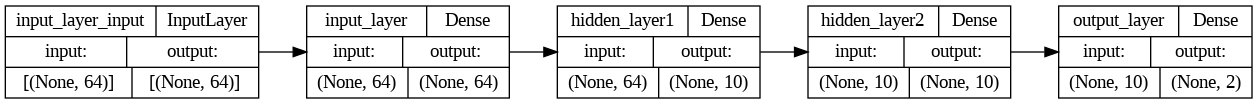

In [49]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

Con el modelo entrenado podemos hacer predicciones usando el subset de datos de testeo y calcular la matriz de confusión del mismo. Puede observarse que el sistema es muy bueno en la predicción de los positivos, no tanto en los negativos, como demuestra el valor más bajo de accuracy.

In [57]:
# Make predictions
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
original_values = np.argmax(y_test.values, axis=1)

# Calculate accuracy and precision
accuracy = accuracy_score(original_values, predictions)
precision = precision_score(original_values, predictions)

# Print results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

# Confusion matrix
MatrizConfusion = confusion_matrix(original_values, predictions)
print("Matriz de Confusión: (TN, FP, FN, TP)")
print(MatrizConfusion)


6/6 [==============================] - 0s 2ms/step
Accuracy: 0.834319526627219
Precision: 0.9130434782608695
Confusion Matrix:
[[ 15  12]
 [ 16 126]]


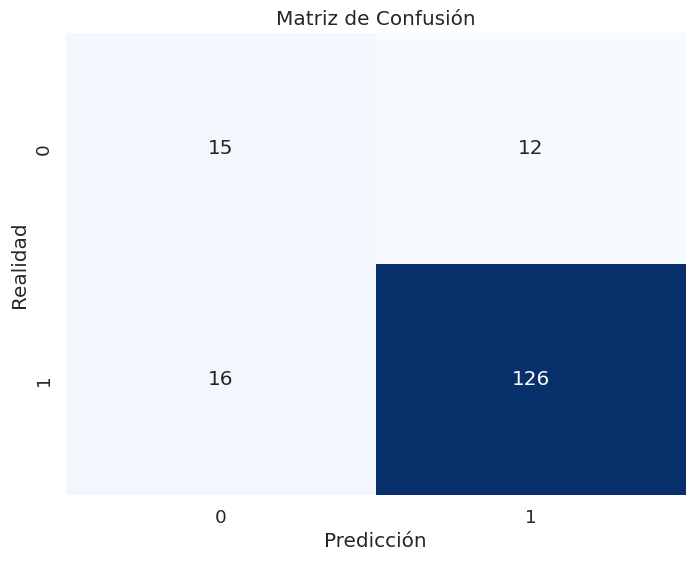

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Tamaño de la fuente
heatmap = sns.heatmap(MatrizConfusion, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas de los ejes
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')

# Mostrar el heatmap
plt.show()
